In [ ]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [ ]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [ ]:
NUM_CLASSES = 6

# 学習データ読み込み

In [ ]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [ ]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [ ]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [ ]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/50 [..............................] - ETA: 17s - loss: 1.8223 - accuracy: 0.2734
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
50/50 [==============================] - 0s 3ms/step - loss: 1.6620 - accuracy: 0.3209 - val_loss: 1.5210 - val_accuracy: 0.3080
Epoch 2/1000
 1/50 [..............................] - ETA: 0s - loss: 1.5046 - accuracy: 0.3516
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
50/50 [==============================] - 0s 1ms/step - loss: 1.4630 - accuracy: 0.3763 - val_loss: 1.3462 - val_accuracy: 0.3739
Epoch 3/1000
 1/50 [..............................] - ETA: 0s - loss: 1.3811 - accuracy: 0.4141
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
50/50 [==============================] - 0s 1ms/step - loss: 1.3558 - accuracy: 0.4087 - val_loss: 1.2421 - val_accuracy: 0.4565
Epoch 4/1000
 1/50 [..............................] - ETA: 0s - loss: 1.3407 - accuracy: 0.4219


In [ ]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

17/17 [==============================] - 0s 508us/step - loss: 0.3697 - accuracy: 0.8405


In [ ]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [ ]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 35ms/step
[1.1095661e-02 1.7012024e-02 1.7685968e-05 6.1690691e-04 5.2966630e-01
 4.4159132e-01]
4


# 混同行列

66/66 [==============================] - 0s 443us/step


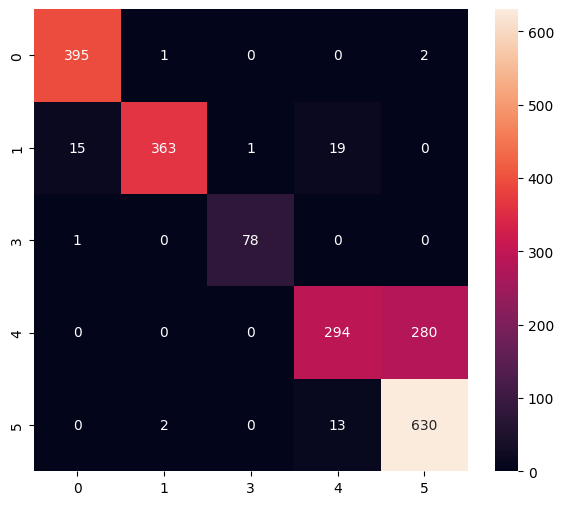

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       398
           1       0.99      0.91      0.95       398
           3       0.99      0.99      0.99        79
           4       0.90      0.51      0.65       574
           5       0.69      0.98      0.81       645

    accuracy                           0.84      2094
   macro avg       0.91      0.88      0.88      2094
weighted avg       0.87      0.84      0.83      2094



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [ ]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [ ]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/7y/jht0wq9156v777kgwmnb4xl40000gn/T/tmpi6973yos/assets


INFO:tensorflow:Assets written to: /var/folders/7y/jht0wq9156v777kgwmnb4xl40000gn/T/tmpi6973yos/assets
2023-08-16 16:23:05.114319: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-16 16:23:05.114342: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-16 16:23:05.114522: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/7y/jht0wq9156v777kgwmnb4xl40000gn/T/tmpi6973yos
2023-08-16 16:23:05.115539: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-08-16 16:23:05.115546: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/7y/jht0wq9156v777kgwmnb4xl40000gn/T/tmpi6973yos
2023-08-16 16:23:05.118669: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-08-16 16:23:05.152816: I tensorflow/cc/saved_model/loader.cc:215] Running initialization

6660

# 推論テスト

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 120 µs, sys: 37 µs, total: 157 µs
Wall time: 166 µs


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.1095666e-02 1.7012041e-02 1.7685958e-05 6.1690720e-04 5.2966654e-01
 4.4159120e-01]
4
